# OpenAI CarRacing with Behavioral Cloning

In this homework, you will train an agent to drive on a race track in a video-game style simulator. The agent has a neural network controller that you will train using example data of a car racing around the track. At each timestep, the neural network takes in the *state* of the car as an image and outputs which *action* to take. 

This system is known as a *Markov Decision Process (MDP)* because at each discrete timestep, the agent makes a decision using only the current state, with no memory of the previous state (this is called Markov property). In the context of Reinforcement Learning, this training strategy is known as *behavioral cloning* because we are learning by copying the actions of another agent.

The simulator is the CarRacing-v0 environment from OpenAI. In this environment, a *state* is a (96,96,3) color image which shows the position of the car along with the current speed, stearing position, and braking status in the bottom of the image. The *actions* that are available to the agent are stear (between -1 and 1), accelerate (0 to 1), and break (0 to 1). To simplify this assignment, I have converted this into a classification problem with only seven discrete actions:

0. Do nothing
1. Left
2. Left+Break
3. Right
4. Right+Break
5. Accelerate!
6. Break

Below is provided a dataset of 11,132 example (state, action) pairs you can use for training. These were sampled from simulations of a highly-skilled AI agent. The first cell downloads the data and installs many of the dependencies needed to run the simulations and generate videos in Google Colab. You should be able to train your agent and view videos of your agent within Colab.

## Tasks:
1.   Create a class called `Agent` with methods 'train' and 'act'.
2.   Train the agent to drive. Optimize hyperparameters such as the learning rate, network architecture, etc. You can do this by hand (you don't need to do anything fancy).
3. Create a video of your agent driving.



xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0
To: /content/carracing_behavior.gzip
100% 6.57M/6.57M [00:00<00:00, 238MB/s]

State data shape (examples, x, y, color): (11132, 96, 96, 3)
Action data shape (examples, action idx): (11132,)

Example state (this is the input to your neural network):


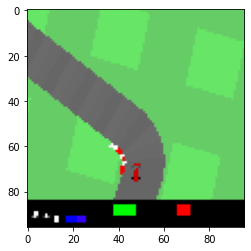

In [1]:
# NO NEED TO MODIFY THIS CELL
# Dependencies for rendering openai gym in colab and enable video recording.
# Remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* piglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
import tensorflow as tf
import numpy as np
import random, math, glob, io, base64
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  return Monitor(env, './video', force=True)

# Download example data for training.
import gzip, os, pickle, random
with gzip.open('carracing_behavior.gzip', 'rb') as f:
    states, action_classes = pickle.load(f)

print('\nState data shape (examples, x, y, color):', states.shape)
print('Action data shape (examples, action idx):', action_classes.shape)

# Plot an example state. This is the model input.
print('\nExample state (this is the input to your neural network):')
plt.imshow(states[0, :, :, :])

# The simulator expects a length-3 array corresponding to stear, 
# accellerate, and break. But I converted the training data actions into a 
# discrete set to frame the problem as classification. This is the set of 
# possible actions. The indices in training data targets (action_classes) 
# correspond to this set of actions. Your agent's act method should
# return one of these, not an integer index.
ACTION_SPACE = [[0, 0, 0],  # no action
                [-1, 0, 0],  # left
                [-1, 0, 1],  # left+break
                [1, 0, 0],  # right
                [1, 0, 1],  # right+break
                [0, 1, 0],  # acceleration
                [0, 0, 1], ]  # break

# Create, Train, and Simulate Agent

Create your agent class below. The code provided should help get you started. Then test your agent in the racing environment.






In [2]:
# WRITE ME
from keras import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
class Agent:  
  def train(self, X, Y):
    val_size = int(X.shape[0] * 30/100)
    indices = np.random.choice(X.shape[0], size=val_size, replace=False)
    X_val = X[indices, :]
    X_train = np.delete(X, indices, 0)
    Y_onehot = to_categorical(Y)
    Y_val = Y_onehot[indices]
    Y_train = np.delete(Y_onehot, indices, 0)
    self.model = Sequential()
    self.model.add(Input(shape=X[0,...].shape))
    self.model.add(Conv2D(15, kernel_size=(3, 3), activation='elu')) # Change 15 to 30 for slow but accurate
    self.model.add(MaxPooling2D(pool_size=(2, 2)))
    self.model.add(Conv2D(20, kernel_size=(8, 8), activation='tanh'))
    self.model.add(MaxPooling2D(pool_size=(4, 4)))
    self.model.add(Conv2D(20, kernel_size=(5, 5), activation='relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))
    self.model.add(Conv2D(20, kernel_size=(3, 3), activation='relu')) # Change relu to exponential for slow but accurate
    self.model.add(Flatten())
    self.model.add(Dense(512, activation='elu'))
    self.model.add(Dense(7, activation='softmax'))
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, baseline=1.4, restore_best_weights = True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto', cooldown=1, min_lr = 1e-5, min_delta = 0.001)
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    self.model.fit(X_train, Y_train, batch_size=100, epochs=999999, 
                   validation_batch_size=100, validation_data=(X_val, Y_val), 
                   callbacks=[early_stopping, reduce_lr], verbose=1)
    return self.model.evaluate(X_val, Y_val)
  
  def act(self, X):
    X_expand = np.expand_dims(X, axis=0)
    action_proba = self.model.predict(X_expand)
    action_index = np.argmax(action_proba[0])
    action = ACTION_SPACE[action_index]
    return action

agent = Agent()
agent.train(states, action_classes)


Epoch 1/999999
78/78 [==============================] - 7s 35ms/step - loss: 1.2900 - accuracy: 0.4324 - val_loss: 1.0919 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/999999
78/78 [==============================] - 2s 25ms/step - loss: 1.0857 - accuracy: 0.5117 - val_loss: 1.0912 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 3/999999
78/78 [==============================] - 2s 23ms/step - loss: 1.0326 - accuracy: 0.5402 - val_loss: 0.9900 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 4/999999
78/78 [==============================] - 2s 23ms/step - loss: 1.0024 - accuracy: 0.5565 - val_loss: 0.9724 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 5/999999
78/78 [==============================] - 2s 20ms/step - loss: 0.9628 - accuracy: 0.5830 - val_loss: 0.9365 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 6/999999
78/78 [==============================] - 1s 17ms/step - loss: 0.9673 - accuracy: 0.5685 - val_loss: 0.9397 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 7/999999
78/78 [==============================

[0.7388283014297485, 0.7011080980300903]

# Simulate Agent

In [3]:
# NO NEED TO MODIFY THIS CELL
# Run simulation for t timesteps.
NUM_TIMESTEPS = 1000  # Increase this to run simulation longer.
with wrap_env(gym.make("CarRacing-v0")) as env: # Exits env when done.
  observation = env.reset()  # Restarts car at the starting line.
  for t in range(NUM_TIMESTEPS):
    env.render() 
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done:
      print("Episode finished after {} timesteps".format(t+1))
      break
show_video()  # Video can be downloaded by clicking option in bottom right.

Track generation: 1129..1415 -> 286-tiles track
Episode finished after 785 timesteps
